In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/NEXCO/src/EDA/

Mounted at /content/drive
/content/drive/MyDrive/NEXCO/src/EDA


In [ ]:
!pip install japanize_matplotlib jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=dd51416fd50b3c0fa0e32edb83141290b99fcf5e79d4168218511d9dbad05918
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize_matplotlib


In [ ]:
# ========================================
# Library
# ========================================
import os
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)# StratifiedGroupKFold, 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

pd.set_option('display.max_columns', None)

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

In [ ]:
train_df = pd.read_csv("../train/train.csv")
search_spec_df = pd.read_csv("../train/search_data.csv")
search_unspec_df = pd.read_csv("../train/search_unspec_data.csv")
road_df = pd.read_csv("../train/road.csv")

In [ ]:
train_df.shape

(910080, 7)

In [ ]:
train_df.head(5)# (910080, 7)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0


In [ ]:
search_spec_df.shape

(910080, 4)

In [ ]:
search_spec_df.head(5)# (910080, 4)

,datetime,start_code,end_code,search_1h
0,2021-04-08 00:00:00,1110210,1800006,15.0
1,2021-04-08 01:00:00,1110210,1800006,6.0
2,2021-04-08 02:00:00,1110210,1800006,3.0
3,2021-04-08 03:00:00,1110210,1800006,26.0
4,2021-04-08 04:00:00,1110210,1800006,31.0


In [ ]:
search_unspec_df.shape

(37920, 4)

In [ ]:
search_unspec_df.head(5)# (37920, 4)

,date,start_code,end_code,search_unspec_1d
0,2021-04-08,1110210,1800006,3448.0
1,2021-04-09,1110210,1800006,2992.0
2,2021-04-10,1110210,1800006,2970.0
3,2021-04-11,1110210,1800006,2992.0
4,2021-04-12,1110210,1800006,2974.0


In [ ]:
road_df.shape

(79, 18)

In [ ]:
road_df.head(5)# (79, 18)

,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code
0,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.90,下り,0.0,9.4,100,1800
1,京葉道路・館山自動車道接続部,市原,1130001,1130006,12,12,35.55136,35.49471,140.143014,140.094986,2.0,2.0,39.17,下り,35.7,43.7,100,1130
2,市原,京葉道路・館山自動車道接続部,1130006,1130001,12,12,35.49471,35.55136,140.094986,140.143014,2.0,2.0,39.17,上り,43.7,35.7,100,1130
3,市原,姉崎袖ヶ浦,1130006,1130016,12,12,35.49471,35.42603,140.094986,140.045153,2.0,2.0,46.27,下り,43.7,53.7,100,1130
4,姉崎袖ヶ浦,市原,1130016,1130006,12,12,35.42603,35.49471,140.045153,140.094986,2.0,2.0,46.27,上り,53.7,43.7,100,1130


In [ ]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    # search_spec_df = expand_datetime(search_spec_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    search_unspec_df['is_holiday'] = search_unspec_df['date'].map(lambda x: jpholiday.is_holiday(x))
    search_unspec_df['is_holiday'] = search_unspec_df['is_holiday'].astype(int)# is_holiday = jpholiday.is_holiday(date)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [ ]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [ ]:
train['section'] = train['start_code'].astype(str)+'_'+train['end_code'].astype(str)

train['straight_dist'] = np.sqrt( (train['end_lat']-train['start_lat'])**2 + (train['end_lng']-train['start_lng'])**2 ) * 100
train['KP_se_dist'] = np.abs(train['end_KP']-train['start_KP'])
train['KP_te_dist'] = np.abs(train['end_KP']-train['KP'])
train['KP_st_dist'] = np.abs(train['KP']-train['start_KP'])
train['KP_max_dist'] = np.max(train[['KP_te_dist', 'KP_st_dist']], axis=1) / train['KP_se_dist']
train['detour_rate'] = train['KP_se_dist']/train['straight_dist']

In [ ]:
'''
train                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)
search                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数
search_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数
road                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP
                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP
                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)
                                                                
                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)
train_df, search_df, search_unspec_df, road_df

train < 時間 > search
train < 日付 > search_unspec
train < sid, eid > road

all_df >> 15+18
'''

'\ntrain                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)\nsearch                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数\nsearch_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数\nroad                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP\n                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP\n                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)\n                                                                \n                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)\ntrain_df, search_df, search_unspec_df, road_df\n\ntrain < 時間 > search\ntrain < 日付 > search_unspec\ntrain < sid, eid > road\n\nall_df >> 15+18\n'

In [ ]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek', 'is_holiday']
num_cols = ['year', 'month', 'day', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed', 'straight_dist', 'KP_se_dist', 'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate']
feature_cols = cat_cols + num_cols

In [ ]:
train.head(5)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,date,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0,2021,4,8,0,15.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0,2021,4,8,1,6.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0,2021,4,8,2,3.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0,2021,4,8,3,26.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0,2021,4,8,4,31.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491


In [ ]:
train.shape

(910080, 37)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910080 entries, 0 to 910079
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          910080 non-null  datetime64[ns]
 1   start_code        910080 non-null  int64         
 2   end_code          910080 non-null  int64         
 3   OCC               910080 non-null  float64       
 4   allCars           910080 non-null  int64         
 5   speed             910080 non-null  float64       
 6   is_congestion     910080 non-null  int64         
 7   year              910080 non-null  int64         
 8   month             910080 non-null  int64         
 9   day               910080 non-null  int64         
 10  hour              910080 non-null  int64         
 11  search_1h         910080 non-null  float64       
 12  date              910080 non-null  datetime64[ns]
 13  search_unspec_1d  910080 non-null  float64       
 14  is_h

In [ ]:
train.describe()

,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,start_KP,end_KP,limit_speed,road_code,dayofweek,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate
count,9.100800e+05,9.100800e+05,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000
mean,1.655645e+06,1.655645e+06,2.603678,873.231072,89.983847,0.004449,2021.441667,6.304167,15.900000,11.50000,22.567348,2062.439425,0.045833,11.696203,11.696203,36.237507,36.237356,139.301040,139.301227,2.202532,2.189873,93.675468,94.317367,94.292051,92.911392,1664.303797,3.01250,6.312220,6.931241,3.657797,3.273443,0.724121,1.087087
std,2.758517e+05,2.758517e+05,2.571047,871.270962,7.946235,0.066553,0.496586,3.078689,8.743955,6.92219,51.064207,1808.973878,0.209124,1.759995,1.759995,0.609746,0.609727,0.399541,0.399440,0.536745,0.529532,61.921437,62.098440,62.102722,9.566812,269.263952,1.99892,3.483787,3.924388,3.320637,3.277406,0.138075,0.105186
min,1.110210e+06,1.110210e+06,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,10.000000,10.000000,35.193970,35.193970,138.784267,138.784267,2.000000,2.000000,3.900000,0.000000,0.000000,80.000000,1130.000000,0.00000,1.790517,1.600000,0.244000,0.330000,0.507692,0.855682
25%,1.800011e+06,1.800011e+06,0.916667,245.000000,87.000000,0.000000,2021.000000,4.000000,8.000000,5.75000,2.000000,706.000000,0.000000,10.000000,10.000000,35.839090,35.839090,139.018083,139.018083,2.000000,2.000000,46.270000,47.500000,47.500000,80.000000,1800.000000,1.00000,4.391609,4.900000,1.190000,1.100000,0.585106,1.023384
50%,1.800066e+06,1.800066e+06,1.916667,513.000000,90.843137,0.000000,2021.000000,6.000000,16.000000,11.50000,8.000000,1469.000000,0.000000,11.000000,11.000000,36.252110,36.252110,139.122931,139.122931,2.000000,2.000000,76.000000,78.700000,78.700000,100.000000,1800.000000,3.00000,6.028817,6.900000,3.080000,2.470000,0.725530,1.097473
75%,1.800111e+06,1.800111e+06,3.666667,1289.000000,94.157971,0.000000,2022.000000,9.000000,23.000000,17.25000,23.000000,2851.000000,0.000000,12.000000,12.000000,36.651900,36.651900,139.506467,139.506467,2.000000,2.000000,128.120000,125.900000,125.900000,100.000000,1800.000000,5.00000,7.795043,8.495000,5.100000,4.000000,0.857143,1.148937
max,1.800183e+06,1.800183e+06,52.500000,5046.000000,120.000000,1.000000,2022.000000,12.000000,31.000000,23.00000,1400.000000,12793.000000,1.000000,15.000000,15.000000,37.390050,37.390050,140.143014,140.143014,4.000000,4.000000,237.700000,238.600000,238.600000,100.000000,1800.000000,6.00000,23.597858,25.954000,25.152000,25.142000,0.969099,1.379507


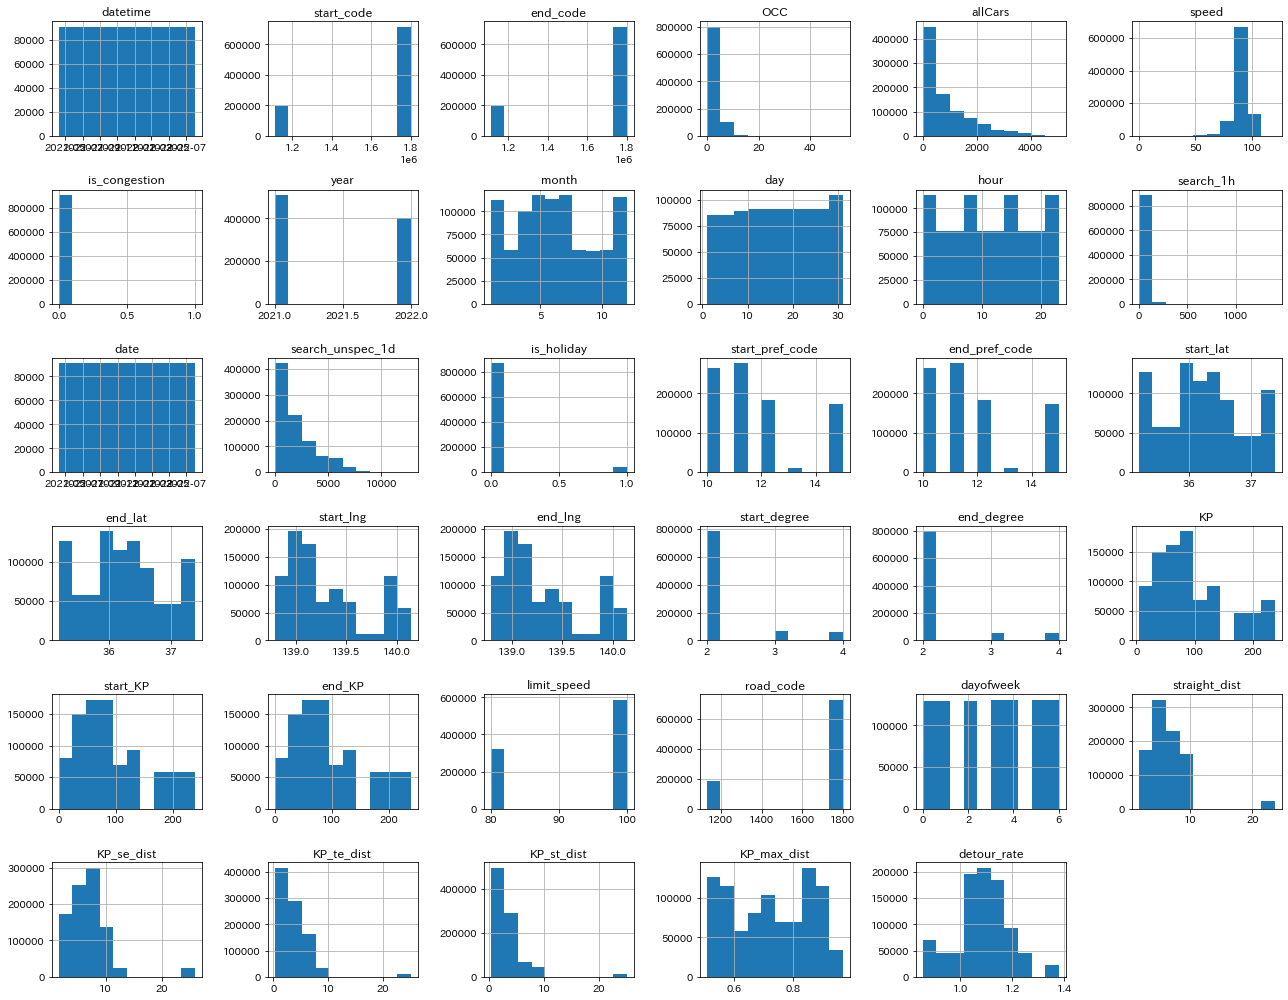

In [ ]:
train.hist(figsize = (18,14)); # 一括でヒストグラムを描画する
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show()

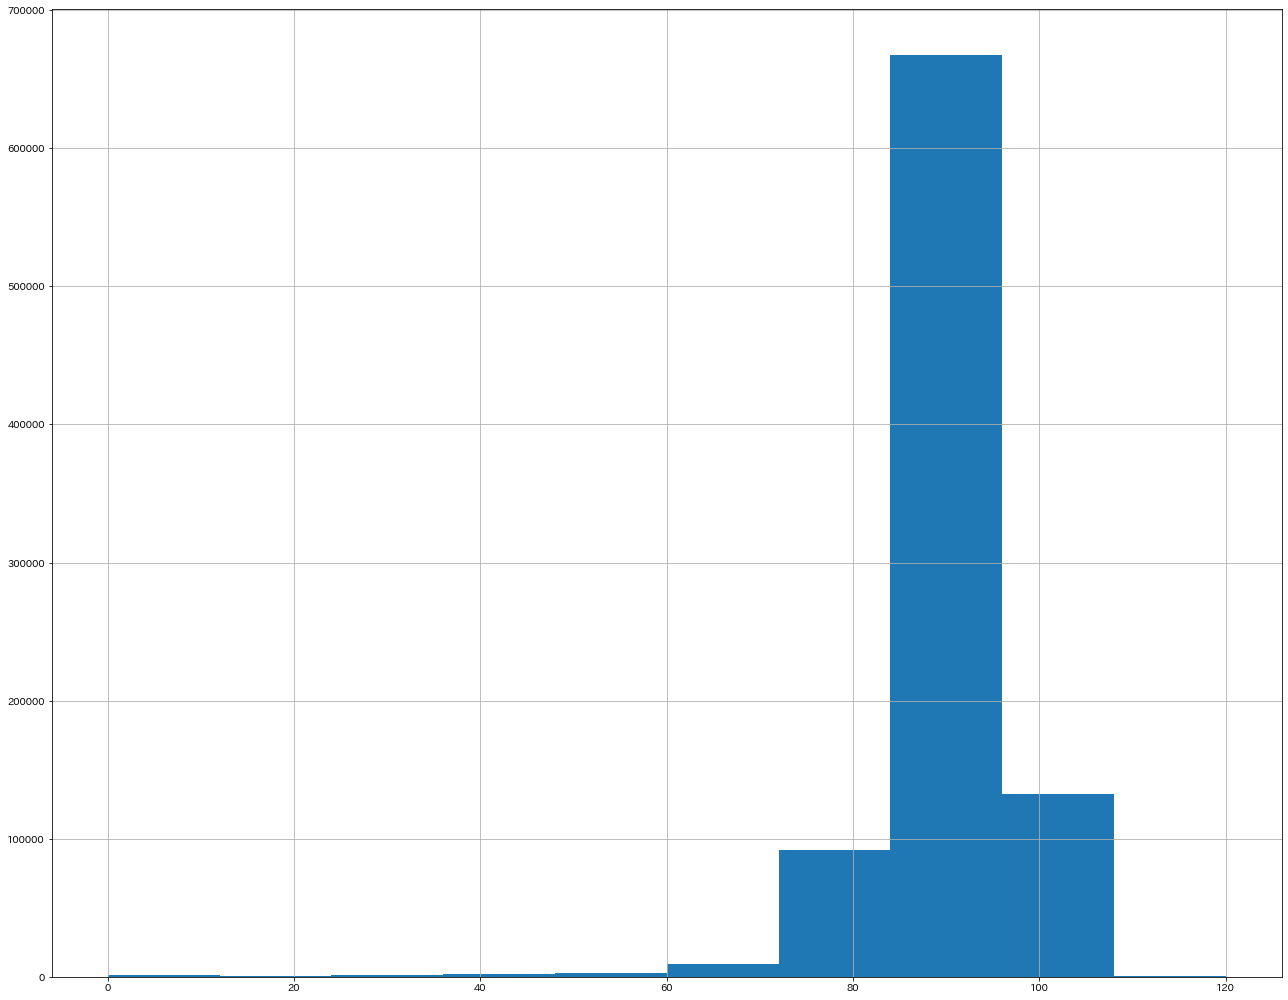

In [ ]:
train['speed'].hist(figsize = (18,14)); # 一括でヒストグラムを描画する
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show()

In [ ]:
for i in range(24):
    print(f'\n===== speed {5*(i+1)} =====')
    temp_df = train[train['speed']<=5*(i+1)]
    temp_df = temp_df[5*i<temp_df['speed']]
    print(temp_df['is_congestion'].value_counts())
# 40以下は全て渋滞


===== speed 5 =====
1    83
Name: is_congestion, dtype: int64

===== speed 10 =====
1    267
Name: is_congestion, dtype: int64

===== speed 15 =====
1    249
Name: is_congestion, dtype: int64

===== speed 20 =====
1    241
Name: is_congestion, dtype: int64

===== speed 25 =====
1    334
Name: is_congestion, dtype: int64

===== speed 30 =====
1    536
Name: is_congestion, dtype: int64

===== speed 35 =====
1    666
Name: is_congestion, dtype: int64

===== speed 40 =====
1    678
Name: is_congestion, dtype: int64

===== speed 45 =====
0    661
Name: is_congestion, dtype: int64

===== speed 50 =====
0    770
Name: is_congestion, dtype: int64

===== speed 55 =====
0    1097
Name: is_congestion, dtype: int64

===== speed 60 =====
0    1661
Name: is_congestion, dtype: int64

===== speed 65 =====
0    2810
Name: is_congestion, dtype: int64

===== speed 70 =====
0    4038
Name: is_congestion, dtype: int64

===== speed 75 =====
0    6254
Name: is_congestion, dtype: int64

===== speed 80 =====


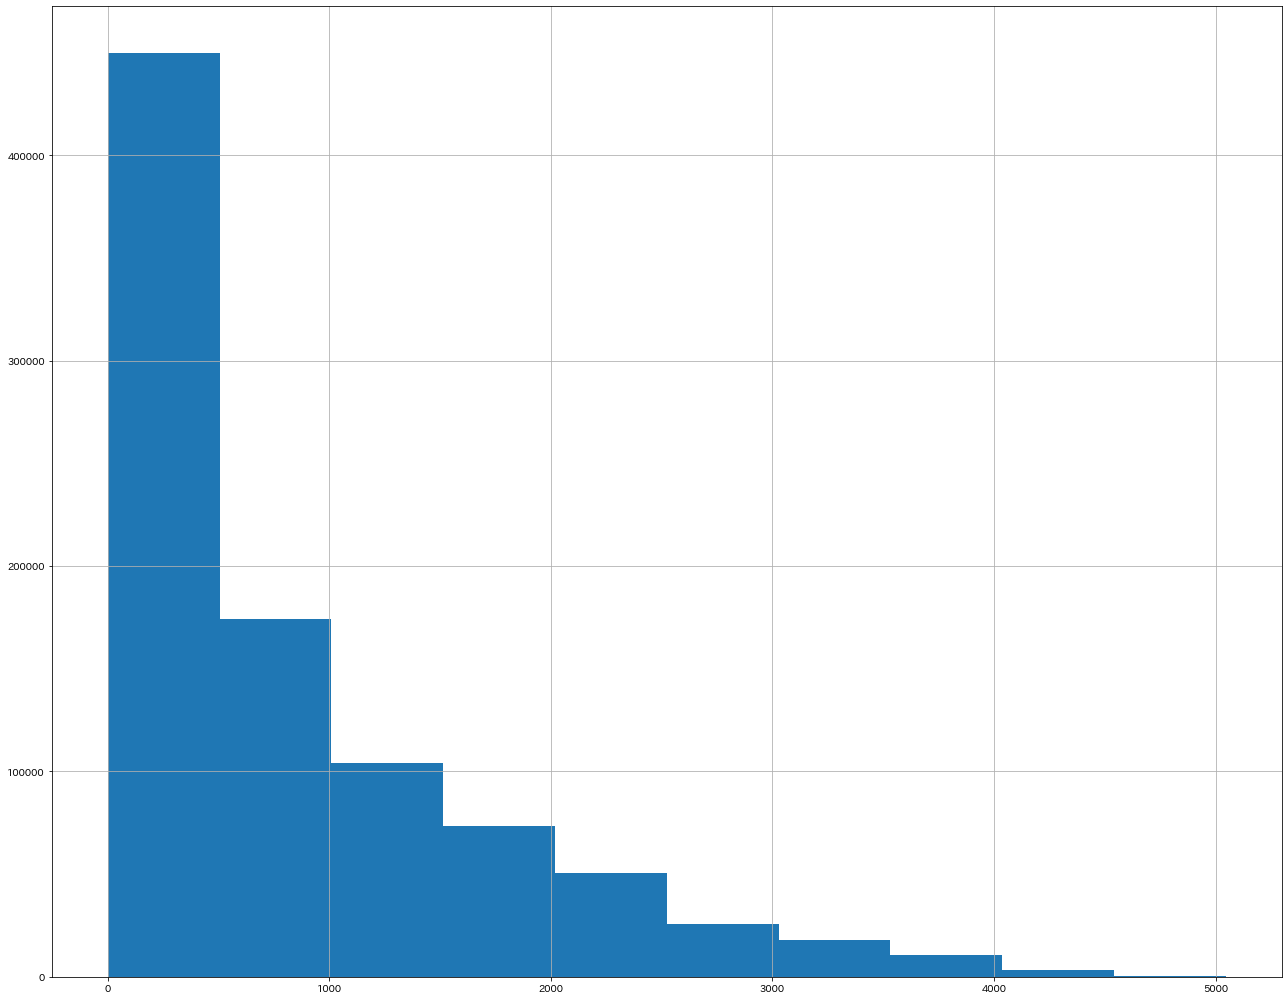

In [ ]:
train['allCars'].hist(figsize = (18,14)); # 一括でヒストグラムを描画する
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show()

In [ ]:
for i in range(10):
    print(f'\n===== cars {5*(i)} =====')
    temp_df = train[train['allCars']<=5*(i)]
    print(temp_df['is_congestion'].value_counts())
# 40以下は全て渋滞


===== cars 0 =====
1    995
Name: is_congestion, dtype: int64

===== cars 5 =====
1    1375
0     147
Name: is_congestion, dtype: int64

===== cars 10 =====
1    1461
0     300
Name: is_congestion, dtype: int64

===== cars 15 =====
1    1493
0     978
Name: is_congestion, dtype: int64

===== cars 20 =====
0    2457
1    1499
Name: is_congestion, dtype: int64

===== cars 25 =====
0    4299
1    1504
Name: is_congestion, dtype: int64

===== cars 30 =====
0    6362
1    1510
Name: is_congestion, dtype: int64

===== cars 35 =====
0    8600
1    1514
Name: is_congestion, dtype: int64

===== cars 40 =====
0    11092
1     1518
Name: is_congestion, dtype: int64

===== cars 45 =====
0    14013
1     1519
Name: is_congestion, dtype: int64
